# 环境变量

In [1]:
output_dir='./output_zero/'
faiss_path=output_dir+'faiss_index'
distilled_log_dir=output_dir+'distilled_log/'
chapter_summary_path=output_dir+'chapter_summary.json'
merged_log_path=output_dir+'merged_log.json'
rename_map_path=output_dir+'rename_map.json'



bg_hint_len=500
retrospect_len=100
summary_chunk_len=500 # shouldn't be too large. because chatgpt's summary is very short. need to fine-tune this number
summary_chunk_overlap=0
final_summary_chunk_len=2000

import os, json
rename_map=json.load(open(rename_map_path,'r',encoding='utf-8')) if os.path.exists(rename_map_path) else {}

# 加载llm

In [2]:
from my_llm import llm_chatgpt as llm
llm('你好')

c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:165: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\llms\openai.py:676: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


你好你好！有什么我可以帮助你的吗？


'你好！有什么我可以帮助你的吗？'

# 加载FAISS背景知识索引

In [3]:
import importlib,my_faiss;importlib.reload(my_faiss)
from my_faiss import FAISS,embeddings,get_bg_hint
get_bg_hint.vector_store=FAISS.load_local(faiss_path, embeddings)

No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.
No sentence-transformers model found with name D:\ml\text2vec-large-chinese. Creating a new one with MEAN pooling.


# 处理gpt返回的json

In [4]:
import json,random
from glob import glob
import os
from tqdm.auto import tqdm

chunks={}
for path in glob(os.path.join(distilled_log_dir,'RESPONSE*.json')):
    with open(path) as f:
        chunk=json.load(f)
        for item in chunk['content']:
            item['src_id']=chunk['id']
        chunks[chunk['id']]=chunk
print('load chunks:',len(chunks))

chunks=dict(sorted(chunks.items(), key=lambda item: item[0]))

all_content=[item for chunk in chunks.values() for item in chunk['content']]


# # separate info, act into individual items
def purge_content(all_content):
    for item in all_content:
        if 'info' in item:
            info_str=item['info']
            if 'expression' in item:
                info_str=item['expression']+' '+info_str
            if 'char' in item:
                info_str=item['char']+' '+info_str
            yield {'info':info_str,'src_id':item['src_id']}
        if 'char' in item:
            base_info={'char':item['char'],'src_id':item['src_id']}
            if 'expression' in item:
                base_info['expression']=item['expression']
            if 'act' in item:
                yield {**base_info,'act':item['act']}
            else:
                if 'think' in item:
                    base_info['think']=item['think']
                if 'say' in item:
                    base_info['say']=item['say']
                if 'think' in item or 'say' in item:
                    yield base_info

all_content=list(purge_content(all_content))

all_content[:10]

print('Total items:', len(all_content))

json.dump(all_content, open(merged_log_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)

load chunks: 455
Total items: 6952


### 统计角色出现的频率，统一名字中的同音字

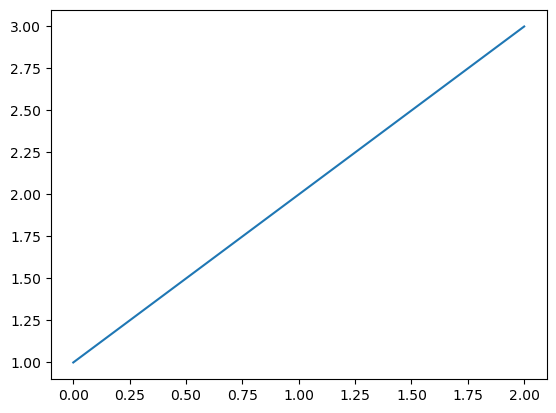

In [5]:
# run this block to avoid crash when loading chinese font in matplotlib
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.figure()
plt.plot([1,2,3])
plt.show()


load, update and save rename_map at path: ./output_zero/rename_map.json


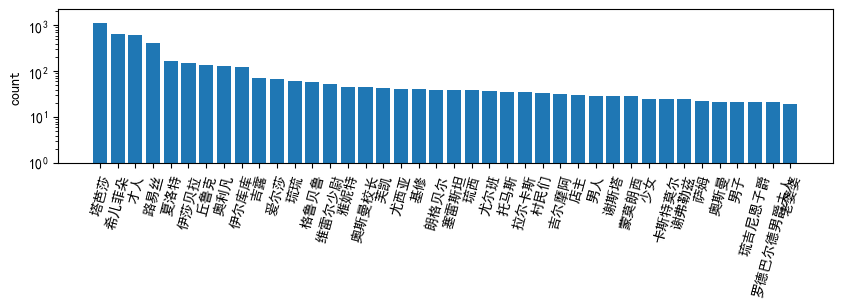

list of characters and their frequencies: {'塔芭莎': 1119, '希儿菲朵': 663, '才人': 601, '路易丝': 410, '夏洛特': 168, '伊莎贝拉': 152, '丘鲁克': 138, '奥利凡': 128, '伊尔库库': 124, '吉露': 72, '爱尔莎': 67, '琉琉': 60, '格鲁贝鲁': 58, '维雷尔少尉': 54, '雅妮特': 45, '奥斯曼校长': 45, '芙凯': 43, '尤西亚': 42, '基修': 41, '朗格贝尔': 40, '塞雷斯坦': 39, '琉西': 39, '尤尔班': 38, '托马斯': 35, '拉尔卡斯': 35, '村民们': 34, '吉尔摩阿': 32, '店主': 30, '男人': 29, '谢斯塔': 29, '蒙莫朗西': 29, '少女': 25, '卡斯特莫尔': 25, '谢弗勒兹': 25, '萨姆': 23, '奥斯曼': 22, '男子': 21, '琉吉尼恩子爵': 21, '罗德巴尔德男爵夫人': 21, '老婆婆': 19, '托马': 19, '村长': 18, '地下水': 18, '艾伯特': 18, '塔巴撒': 18, '爱夏': 17, '琪尔可': 17, '库尔凯': 17, '米诺塔洛斯': 17, '雌火龙': 16, '德福林哥': 16, '侍女': 15, '亚尔托瓦伯': 15, '魔法师': 15, '哥布灵萨满': 15, '军官': 14, '女头目': 14, '学生们': 13, '库拉威尔卿': 13, '奥尔良公': 12, '朗格贝尔小姐': 12, '母亲': 11, '尼娜': 11, '弗雷姆': 11, '小明': 11, '奥斯曼先生': 11, '阿利克山大': 10, '叽叽的父亲': 10, '奥斯曼氏': 10, '马鲁托': 10, '露易丝': 9, '魔杖': 9, '贵族学生们': 8, '贵族客人': 8, '村民': 7, '雷昂': 7, '女孩': 7, '卫士': 7, '叽叽': 7, '塔芭莎施': 7, '德鲁': 7, '亚尔罗瓦伯': 6, '其他学生': 6, '贝尔丹蒂': 6, '水兵': 6, '

In [6]:
matplotlib.rcParams['font.sans-serif'] = ['SimHei']


rename_map=json.load(open(rename_map_path,'r',encoding='utf-8')) if os.path.exists(rename_map_path) else {}
rename_map_added={'塔巴萨':'塔芭莎','塔巴莎':'塔芭莎','雪丝塔':'谢斯塔','摩莫朗希':'蒙莫朗西','夏尔洛特':'夏洛特','希尔菲德':'希儿菲朵','西布鲁兹':'谢弗勒兹','谢丝塔':'谢斯塔'}
rename_map.update(rename_map_added)
json.dump(rename_map, open(rename_map_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('load, update and save rename_map at path:', rename_map_path)

# we use the original name in history text, but the new name for labeling

char_freq={}
for item in all_content:
    if 'char' in item:
        char=rename_map.get(item['char'], item['char'])
        if char not in char_freq:
            char_freq[char]=0
        char_freq[char]+=1
char_freq={k: v for k, v in sorted(char_freq.items(), key=lambda item: item[1], reverse=True)}
selected_char=list(sorted(char_freq.keys(), key=lambda x: char_freq[x], reverse=True)[:9999])

def list_char_items(content, char):
    for item in content:
        if item.get('char', None) == char:
            print(item)


plt.figure(figsize=(10, 2))
plt.bar(list(char_freq.keys())[:40], list(char_freq.values())[:40])
plt.xticks(rotation=75)
plt.ylabel('count')
plt.yscale('log')
plt.ylim(1,np.max(list(char_freq.values())[:20])*2)
plt.show()

print('list of characters and their frequencies:',char_freq)
print('rename_map:', rename_map)
print('selected_char:', selected_char)

# revising character name typo

def revise_name(obj):
    if isinstance(obj,str):
        for from_name,to_name in rename_map.items():
            obj=obj.replace(from_name,to_name)
        return obj,True
    else:
        return obj,False

def revise_json_object_recursive(obj,revise_func):
    obj,terminate=revise_func(obj)
    if not terminate:
        if isinstance(obj,dict):
            for key,value in obj.items():
                obj[key]=revise_json_object_recursive(value,revise_func)
        if isinstance(obj,list):
            for i in range(len(obj)):
                obj[i]=revise_json_object_recursive(obj[i],revise_func)
    return obj

all_content=revise_json_object_recursive(all_content,revise_func=revise_name)
chunks=revise_json_object_recursive(chunks,revise_func=revise_name)
print('revise name done (not saved yet)')

json.dump(all_content, open(merged_log_path, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print('save merged_log_path:', merged_log_path)

# 将chunk合并成章节，并进行总结

In [29]:
chapters=dict()

for iChunk,chunk in sorted(chunks.items()):
    chapter=chapters.get(chunk['chapter_id'], {})
    chapter['chapter_id']=chunk['chapter_id']
    chapter['title']=chunk['title']
    chapter['chunk_ids']=chapter.get('chunk_ids', [])+[chunk['id']]
    chapter['chunk_summaries']=chapter.get('chunk_summaries', [])+[chunk['summary']]
    chapters[chunk['chapter_id']]=chapter

with open(chapter_summary_path, 'w', encoding='utf-8') as f:
    json.dump(chapters, f, ensure_ascii=False, indent=2)
print('chapter summary saved to', chapter_summary_path)


chapter summary saved to ./output_zero/chapter_summary.json


### 将chunk的summary和bg_hint合并，作为chapter的summary

In [36]:
from langchain.chains.base import Chain
import json
import re
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

class FurtherSummaryStoryChain(Chain):
    llm:object=None
    get_bg_hint:object=None
    refine_bg_hint:bool=True
    bg_hint_num:int=10
    bg_hint_len:int=400
    retrospect_len:int=100
    @property
    def input_keys(self):
        return ['text']
    @property
    def output_keys(self):
        return ['summary']
    prmopt='''
可能有关的背景材料
{background}
【前情提要：{retrospect}】
请去除下面情节梗概中重复的部分，请尽量不要丢掉信息。不要加入额外的推测，请忠实于原著。不要加入没有意思的套话。
{text}
精简后的情节梗概：'''
    def _call(self,inputs:dict)->dict:
        print('requesting summary')
        bghint_input=inputs.get('summary',inputs['text'])
        if self.get_bg_hint is not None:
            bg_hint=self.get_bg_hint(bghint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len)
        else:
            bg_hint='（无）'
        inputs['background']=bg_hint[-self.bg_hint_len:]
        inputs['retrospect']=inputs['retrospect'][-self.retrospect_len:]
        query=self.prmopt.format(**inputs)
        response=self.llm(query)
        response=re.sub(r'[\s]*[\d]+[\.、][\s]*','',response)
        if self.refine_bg_hint and 'summary' not in inputs:
            print('refine the summary by using the bg hint genereated by the current summary')
            return self._call({**inputs,'summary':response})
        else:
            return {'summary':response}
    




further_summary_story_chain=FurtherSummaryStoryChain(llm=llm,get_bg_hint=get_bg_hint,
                                            bg_hint_len=bg_hint_len,retrospect_len=retrospect_len)
text_splitter=RecursiveCharacterTextSplitter(chunk_size=summary_chunk_len,chunk_overlap=summary_chunk_overlap)

def further_summary_story(summaries,retrospect=None,final_summary_chunk_len=250):
    all_summary_text='\n'.join([summary.replace('\n','') for summary in summaries])
    retrospect=retrospect or '（无）'
    if len(all_summary_text)<=final_summary_chunk_len:
        print('length of all summaries is less than final_summary_chunk_len, no further summarizing')
        if len(summaries)==1:
            return []
        else:
            return [['\n'.join(summaries)]]
    else:
        print('further summarizing story, num of summaries at current level:',len(summaries), 'total length:',sum([len(summary) for summary in summaries]))
        text_chunks=text_splitter.split_text(all_summary_text)
        chunk_summaries=[]
        chunk_retrospect=''
        for text_chunk in text_chunks:
            all_retrospect=(retrospect+'。'+chunk_retrospect).replace('\w','')
            chunk_summary=further_summary_story_chain({'text':text_chunk,'retrospect':all_retrospect})['summary']
            chunk_retrospect=chunk_summary
            chunk_summaries.append(chunk_summary)
        cascades=further_summary_story(chunk_summaries,retrospect,final_summary_chunk_len=final_summary_chunk_len)
        return cascades+[chunk_summaries]

# llm.show_query=llm.show_response=True

# summaries=chapters[23]['chunk_summaries']
# # summaries=chapters[21]['chunk_summaries']+chapters[22]['chunk_summaries']+chapters[23]['chunk_summaries']
# summary_cascades=further_summary_story(summaries,retrospect='（无）',final_summary_chunk_len=final_summary_chunk_len)
# summary=summary_cascades[0]
# print('summary:',summary)

# llm.show_query=llm.show_response=False

In [37]:
from my_chains import Text2JsonChain

class ExtractStoryElementsChain(Text2JsonChain):
    get_bg_hint:object=None
    bg_hint_num:int=10
    bg_hint_len:int=400
    summary_len:int=100
    retrospect_len:int=100
    story_summary_chain:object=None
    prompt='''可能有关的背景信息：（不要加入到回复中）
{background}
【前情提要：{retrospect}】
【本段概要：{summary}】
对下文中的主要角色，分条提取角色动机motivation，遇到的主要阻碍obstacle，所做出的行为与决策action，以及和这一切有关的角色性格特征trait，和背景信息background。
只需要输出主要角色，按你认为的角色的重要性排序。
输出格式：{{
    "小明":{{
        "motivation":"上街买菜",
        "obstacle":"没钱",
        "action":"找人借钱",
        "trait":"小明很穷",
        "role":"小明在情节中扮演的角色",
        "background":"菜涨价了",
        "development":"小明决定以后不买菜了",
        "reflection":"这段文字展现小明很可怜"
    }}
}}
确保json格式正确。
不加自己的推测想法，请忠实于原著。不要加入没有意思的套话。请修正可能被搞混淆的角色名字。
可能有关的背景信息：（不要加入到回复中）
文本：
{text}
json：'''
    @property
    def output_keys(self):
        return super().output_keys+['summary','background','retrospect']
    def _call(self,inputs:dict)->dict:
        summary=self.story_summary_chain(inputs)['summary'] if self.story_summary_chain is not None else '（无）'
        bg_hint_input=summary if 'summary' in inputs else inputs['text']
        bg_hint=self.get_bg_hint(bg_hint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len) if self.get_bg_hint is not None else '（无）'
        retrospect=inputs.get('retrospect','（无）')

        inputs['summary']=summary.replace('\n','').strip()[:self.summary_len]
        inputs['background']=bg_hint.strip()[-self.bg_hint_len:]
        inputs['retrospect']=retrospect.replace('\n','').strip()[-self.retrospect_len:]

        print('requesting ExtractStoryElementsChain')
        outputs=super()._call(inputs)
        outputs['summary']=summary.replace('\n','')
        outputs['background']=bg_hint
        outputs['retrospect']=retrospect.replace('\n','')
        return outputs
    
extract_story_elements_chain=ExtractStoryElementsChain(llm=llm,get_bg_hint=get_bg_hint,story_summary_chain=further_summary_story_chain,
                                            bg_hint_len=bg_hint_len,retrospect_len=retrospect_len)


llm.show_query=llm.show_response=True

extract_story_elements_chain('\n'.join(summary_cascades[0]))

llm.show_query=llm.show_response=False

requesting summary


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:60                                                                                   │
│                                                                                                  │
│ c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\chains\base.py:116 in __call__          │
│                                                                                                  │
│   113 │   │   │   outputs = self._call(inputs)                                                   │
│   114 │   │   except (KeyboardInterrupt, Exception) as e:                                        │
│   115 │   │   │   self.callback_manager.on_chain_error(e, verbose=self.verbose)                  │
│ ❱ 116 │   │   │   raise e                                                                        │
│   117 │   │   self.callback_manager.on_chain_end(outputs, verbose=self.verbose)                  │
│   118 │   │   return self.prep_outputs(inputs, outputs, return_only_outputs)                     │
│   119                                                                                            │
│                                                                                                  │
│ c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\chains\base.py:113 in __call__          │
│                                                                                                  │
│   110 │   │   │   verbose=self.verbose,                                                          │
│   111 │   │   )                                                                                  │
│   112 │   │   try:                                                                               │
│ ❱ 113 │   │   │   outputs = self._call(inputs)                                                   │
│   114 │   │   except (KeyboardInterrupt, Exception) as e:                                        │
│   115 │   │   │   self.callback_manager.on_chain_error(e, verbose=self.verbose)                  │
│   116 │   │   │   raise e                                                                        │
│ in _call:38                                                                                      │
│                                                                                                  │
│ c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\chains\base.py:116 in __call__          │
│                                                                                                  │
│   113 │   │   │   outputs = self._call(inputs)                                                   │
│   114 │   │   except (KeyboardInterrupt, Exception) as e:                                        │
│   115 │   │   │   self.callback_manager.on_chain_error(e, verbose=self.verbose)                  │
│ ❱ 116 │   │   │   raise e                                                                        │
│   117 │   │   self.callback_manager.on_chain_end(outputs, verbose=self.verbose)                  │
│   118 │   │   return self.prep_outputs(inputs, outputs, return_only_outputs)                     │
│   119                                                                                            │
│                                                                                                  │
│ c:\Anaconda3\envs\tensorflow\lib\site-packages\langchain\chains\base.py:113 in __call__          │
│                                                                                                  │
│   110 │   │   │   verbose=self.verbose,                                                          │
│   111 │   │   )                                                                                  │
│   112 │   │   try:                                                                               │
│ ❱ 113 │   │   │   outputs = self._call(inputs)             

# Trash code after here

In [ ]:
class FinalSummaryStoryChain(Chain):
    llm:object=None
    get_bg_hint:object=None
    bg_hint_num:int=10
    bg_hint_len:int=400
    retrospect_len:int=100
    @property
    def input_keys(self):
        return ['text','retrospect']
    @property
    def output_keys(self):
        return ['summary']
    prmopt='''
可能有关的背景材料
{background}
【前情提要：{retrospect}】
问：下面是一个完整的小说章节中不同段落的分段梗概，请用连贯的语言详述一下本小说章节。不要加入额外的推测，请忠实于原著，不要加入没有意思的概概而谈的套话。
{text}
答：'''
    def _call(self,inputs:dict)->dict:
        bghint_input=inputs['text']
        if self.get_bg_hint is not None:
            bg_hint=self.get_bg_hint(bghint_input,k=self.bg_hint_num,max_text_len=self.bg_hint_len)
        else:
            bg_hint='（无）'
        inputs['background']=bg_hint[-self.bg_hint_len:]
        inputs['retrospect']=inputs['retrospect'][-self.retrospect_len:]
        query=self.prmopt.format(**inputs)
        print('requesting summary')
        response=self.llm(query)
        response=re.sub(r'[\s]*[\d]+[\.、][\s]*','',response)
        return {'summary':response}